In [ ]:
#기본 모듈 불러오기
import os
import json
import pandas as pd
from pandas import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

# 전처리
- json 형태 값 -> 데이터 프레임으로 변환
- 'date','visitStartTime': datetime으로 변경
    - 'visitStartTime' : POSIX time (협정 세계시 1970년 1월 1일 00:00:00부터 경과한 시간을 초로 환산)
- 범주형 변수 인코딩

In [ ]:
# json 형태 -> 데이터 프레임으로 변환
def load_df(csv_path='../input/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'},
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = pd.json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

df = load_df('C:/Users/82104/Desktop/스파르타_데이터부트캠프/VSCODE/과제2/train.csv')

In [ ]:
# 열 drop
drop_df = df.drop(['socialEngagementType','device_browser','device_browserVersion','device_operatingSystem','device_browserSize','device_operatingSystemVersion',
        'device_mobileDeviceBranding','device_mobileDeviceModel','device_mobileInputSelector','device_mobileDeviceInfo','device_mobileDeviceMarketingName',
        'device_flashVersion','device_language','device_screenColors','device_screenResolution','geoNetwork_subContinent','geoNetwork_region','geoNetwork_metro',
        'geoNetwork_city','geoNetwork_cityId','geoNetwork_networkDomain','geoNetwork_latitude','geoNetwork_longitude','geoNetwork_networkLocation',
        'trafficSource_adwordsClickInfo.criteriaParameters','trafficSource_referralPath','trafficSource_adwordsClickInfo.page','trafficSource_adwordsClickInfo.gclId',
        'trafficSource_adwordsClickInfo.isVideoAd','trafficSource_adContent','trafficSource_campaignCode'], axis=1)


In [ ]:
# date 열 int형 -> 날짜형으로 변경
drop_df['date'] = pd.to_datetime(drop_df['date'],format='%Y%m%d')
drop_df['visitStartTime'] = pd.to_datetime(drop_df['visitStartTime'],unit='s')


#int형으로 변환
# 값이 없는 cell 전처리
drop_df['totals_visits'] = drop_df['totals_visits'].fillna(0)
drop_df['totals_hits'] = drop_df['totals_hits'].fillna(0)
drop_df['totals_pageviews'] = drop_df['totals_pageviews'].fillna(0)
drop_df['totals_bounces'] = drop_df['totals_bounces'].fillna(0)
drop_df['totals_newVisits'] = drop_df['totals_newVisits'].fillna(0)
drop_df['totals_transactionRevenue'] = drop_df['totals_transactionRevenue'].fillna(0)

# int변환
drop_df['totals_visits'] = drop_df['totals_visits'].astype(int)
drop_df['totals_hits'] = drop_df['totals_hits'].astype(int)
drop_df['totals_pageviews'] = drop_df['totals_pageviews'].astype(int)
drop_df['totals_bounces'] = drop_df['totals_bounces'].astype(int)
drop_df['totals_newVisits'] = drop_df['totals_newVisits'].astype(int)
drop_df['totals_transactionRevenue'] = drop_df['totals_transactionRevenue'].astype(float)

#drop_df['totals_transactionRevenue'] = np.power(drop_df['totals_transactionRevenue'], 1/6).round(2)

#str형으로 변환
drop_df['visitId'] = drop_df['visitId'].astype(str)

In [ ]:
# 범주형 변수 -> 수치형 변수로 변환
# 인코딩 하는 이유: 범주형 변수를 넣는 경우 에러가 발생할 수 있어 수치형으로 변환하는 과정이 필요하다

# 라벨인코딩
"""
label_encoder = LabelEncoder()
object_cols = df.select_dtypes(include=['object']).columns
for col in object_cols:
    df[col] = label_encoder.fit_transform(df[col])

df.head(3)
"""

## 요일, 시간대별 사용자
- 0: 월요일, 1: 화요일, ..., 6: 일요일

In [ ]:
drop_df['day_of_week'] = drop_df['date'].dt.dayofweek
drop_df['hour_of_day'] = drop_df['visitStartTime'].dt.hour


In [ ]:
# 각 요일별 사용자 수 계산
users_per_day = drop_df.groupby('day_of_week')['fullVisitorId'].nunique()

# 그래프 그리기
plt.figure(figsize=(10, 6))
users_per_day.plot(kind='bar', color='skyblue')
plt.title('Number of Users per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Users')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

In [ ]:
# 각 시간대별 이용자 수 계산
users_per_hour = drop_df.groupby('hour_of_day')['fullVisitorId'].nunique()

# 그래프 그리기
plt.figure(figsize=(10, 6))
users_per_hour.plot(kind='bar', color='skyblue')
plt.title('Number of Users per Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.show()

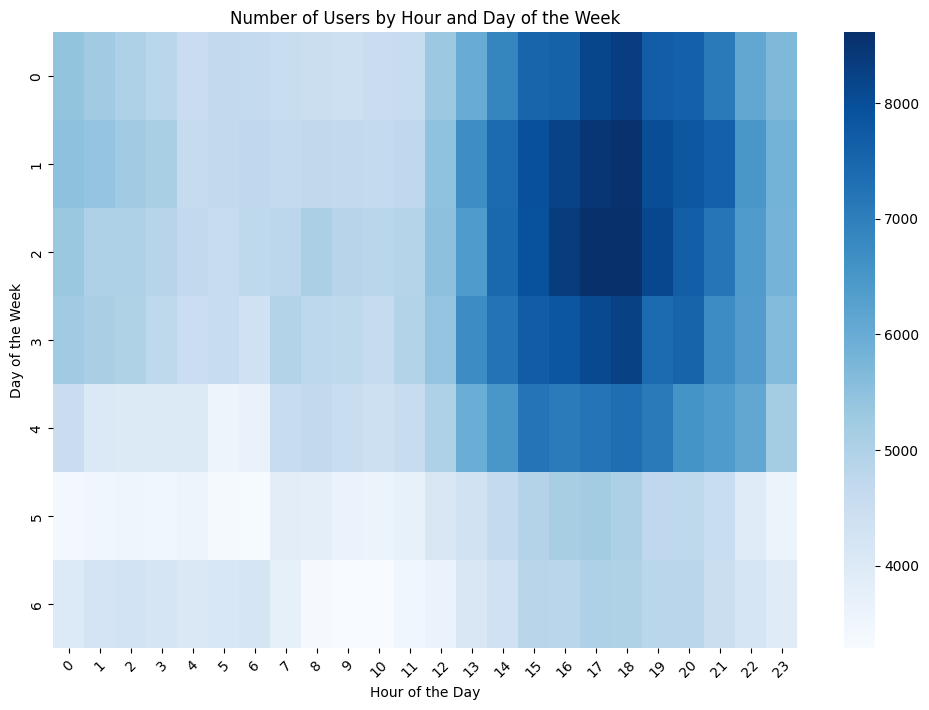

In [26]:
# x축: 시간 y축: 요일
pivot_table = drop_df.pivot_table(index='day_of_week', columns='hour_of_day', values='fullVisitorId', aggfunc='count')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='Blues', annot=False, fmt='d')
plt.title('Number of Users by Hour and Day of the Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.xticks(rotation=45)
plt.show()

## 방문 주차에 따른 코호트 생성 및 weekly 리텐션 구하기
- 보유 데이터: 2016.8.1 ~ 2017.8.1

In [ ]:
drop_df['signup_week'] = drop_df.groupby('fullVisitorId')['date'].transform('min').dt.isocalendar().week
cohort_counts = drop_df.groupby(['signup_week', drop_df['date'].dt.isocalendar().week]).size().unstack(fill_value=0)

plt.figure(figsize=(10, 8))
sns.heatmap(cohort_counts, annot=False, fmt='d', cmap='Blues')
plt.title('Cohort Analysis Heatmap')
plt.xlabel('Visit Week')
plt.ylabel('First_Visit Week')
plt.show()